Загружаем необходимые данные

In [99]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [100]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [101]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [102]:
import numpy as np
import pandas as pd
from random import randint
import torch
from torch.utils.data import (TensorDataset,
                              DataLoader,
                              RandomSampler)

from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import AutoConfig, AutoModelForSequenceClassification
from transformers import (AutoTokenizer,
                          AutoModelForCausalLM,
                          Trainer,
                          TrainingArguments,
                          TrainerCallback,
                          AdamW,
                          get_linear_schedule_with_warmup)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [103]:
device = 'cuda'
device = torch.device(device)

print(device.type)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

cuda
Tesla T4


In [104]:
!pip install chardet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
import chardet
with open('/content/drive/MyDrive/Bert/2 STEP (название).csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'UTF-8-SIG', 'confidence': 1.0, 'language': ''}

In [107]:
df = pd.read_csv('/content/drive/MyDrive/Bert/2 STEP (название).csv', encoding='UTF-8-SIG', sep=';')
# Размер нашей выборки
df.shape

(105000, 3)

In [108]:
df.sample(5)

,Unnamed: 0,name,category_1
82815,56756,СБУ отчиталась о поимке во Львове двух агентов...,Украина
100172,84606,Центробанк поднял курс евро на рубль,Госэкономика
98641,59422,ФСБ пресекла попытку въезда в Крым цыган из За...,Украина
77174,53027,Российских следователей обстреляли с территори...,Украина
29854,12537,Главу ЦИК Латвии заподозрили в незаконной выпл...,Все


In [109]:
df.category_1.unique()

array(['Все', 'Украина', 'Футбол', 'Общество', 'Политика', 'Происшествия',
       'Госэкономика'], dtype=object)

In [110]:
# Присвоим каждой категории индекс, чтобы подавать в модель
category_index = {i[1]:i[0] for i in enumerate(df.category_1.unique())}
# обратное преобразование - индекс метки в текст, этот словарь нам понадобится 
# после обучения для большей наглядности, чтобы видеть, к какой категории товар 
# отнесён моделью
category_index_reverce = {i[0]:i[1] for i in enumerate(df.category_1.unique())}

In [111]:
category_index

{'Все': 0,
 'Украина': 1,
 'Футбол': 2,
 'Общество': 3,
 'Политика': 4,
 'Происшествия': 5,
 'Госэкономика': 6}

In [112]:
category_index_reverce

{0: 'Все',
 1: 'Украина',
 2: 'Футбол',
 3: 'Общество',
 4: 'Политика',
 5: 'Происшествия',
 6: 'Госэкономика'}

In [113]:
# Переведём все метки датасета в числа
sentences = df.name.values
labels = [category_index[i] for i in df.category_1.values]

In [114]:
# Каждому предложению (названию товара) теперь соответсвует не название категории, а её индекс:
sentences[22], labels[22]

(' а пять лет спустя был избран на второй срок. На посту президента в 2005 году его сменил Сергей Багапш. В ходе грузино-абхазского вооруженного конфликта Ардзинба руководил государственным комитетом обороны. Пост президента он занял в 1994 году',
 0)

In [115]:
# Проверим, что все данные корректны
assert len(sentences) == len(labels) == df.shape[0]

In [116]:
sentences = ['[CLS] ' + sentence + ' [SEP]' for sentence in sentences]

In [117]:
train_sentences, test_sentences, train_category, test_category = train_test_split(sentences, labels, test_size=0.005)

In [118]:
len(train_sentences), len(test_sentences)

(104475, 525)

In [119]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('/content/drive/MyDrive/Bert/Out_Bert_Finetuned')

Some weights of the model checkpoint at /content/drive/MyDrive/Bert/Out_Bert_Finetuned were not used when initializing BertForMaskedLM: ['taskmodels_dict.clas.bert.encoder.layer.2.attention.output.LayerNorm.weight', 'taskmodels_dict.rumed.bert.encoder.layer.4.attention.self.query.weight', 'encoder.encoder.layer.11.output.LayerNorm.bias', 'encoder.encoder.layer.1.output.LayerNorm.weight', 'taskmodels_dict.rumed.bert.encoder.layer.11.output.dense.weight', 'taskmodels_dict.rumed.bert.encoder.layer.3.output.LayerNorm.weight', 'taskmodels_dict.rumed.bert.encoder.layer.5.attention.self.key.weight', 'taskmodels_dict.rumed.bert.encoder.layer.3.attention.output.LayerNorm.bias', 'taskmodels_dict.clas.bert.encoder.layer.3.attention.output.LayerNorm.bias', 'encoder.encoder.layer.8.output.LayerNorm.weight', 'taskmodels_dict.rumed.bert.encoder.layer.11.intermediate.dense.weight', 'encoder.encoder.layer.11.attention.self.query.weight', 'taskmodels_dict.rumed.bert.encoder.layer.0.output.dense.bias', '

In [120]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]

In [121]:
# Посмотрим, что получилось
print(tokenized_texts[42])

['[CLS]', 'ч', '##л', '##е', '##н', '##ы', 'п', '##а', '##р', '##л', '##а', '##м', '##е', '##н', '##т', '##а', 'в', '##е', '##н', '##е', '##с', '##у', '##э', '##л', '##ы', 'п', '##о', '##д', '##р', '##а', '##л', '##и', '##с', '##ь', 'м', '##е', '##ж', '##д', '##у', 'с', '##о', '##б', '##о', '##и', '[SEP]']


In [122]:
# ииндексы токенов
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

(array([1.8903e+04, 8.5339e+04, 1.3100e+02, 4.5000e+01, 2.3000e+01,
        1.5000e+01, 6.0000e+00, 8.0000e+00, 1.0000e+00, 4.0000e+00]),
 array([  5. ,  39.2,  73.4, 107.6, 141.8, 176. , 210.2, 244.4, 278.6,
        312.8, 347. ]),
 <a list of 10 Patch objects>)

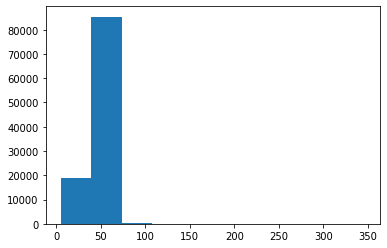

In [123]:
# Соберём все размеры последовательностей
lenths = [len(sent) for sent in tokenized_texts]
# Посмотрим, как они распределяются
plt.hist(lenths)

In [124]:
# Выравниваем датасет. Возьмём размер, равный 24
input_ids = pad_sequences(
    input_ids,
    # максимальная длина предложения
    maxlen=24,
    dtype='long',
    truncating='post',
    padding='post'
)

In [125]:

# Вот, что у нас в результате получилось
# Как видно, в этом примере меньше 24 токенов, поэтому в конец был добавлен паддинг
input_ids[42]
     

array([  101,  1202, 29436, 15290, 18947, 29113,  1194, 10260, 16856,
       29436, 10260, 29745, 15290, 18947, 22919, 10260,  1182, 15290,
       18947, 15290, 29747, 29748, 29756, 29436])

In [126]:

# Создадим маску внимания для каждого сэмпла обучающей выборки.
# единицами отметим те токены, которые нужно учитывать при обучении и вычислении градиентов,
# нулями - те, которые следует пропустить.
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [127]:

print(attention_masks[42])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [128]:
# каждая маска соответсвует своей последовательности
assert len(input_ids[42]) == len(attention_masks[42])

In [129]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_category, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

In [130]:
assert len(train_inputs) == len(train_labels) == len(train_masks)
assert len(validation_inputs) == len(validation_labels) == len(validation_masks)

In [131]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [132]:
from torch.utils.data import SequentialSampler

In [133]:
# специальная обёртка для работы с Тензор-датасетами, в Pytorch есть и другие,
# также можно и свою обёртку написать, для нашей же задачи вполне хватит уже существующих
# в библиотеке инструментов. Используя их мы существенно сокращаем свой код.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    # Данные по батчам разбиваем произвольно с помощью RandomSampler
    sampler=RandomSampler(train_data),
    batch_size=64
)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=64
)

In [ ]:
config = AutoConfig.from_pretrained(model,
                                    num_labels=len(category_index),
                                    id2label=category_index_reverce,
                                    label2id=category_index)

In [ ]:
#Загружаем модель, передаём ей наш конфиг
model = AutoModelForSequenceClassification.from_pretrained(model, config=config)

In [ ]:
# Отправим на видеокарту, заодно посмотрим архитектуру нашего Берта
model.cuda()

In [ ]:
# Гипепараметры модели. Их можно изменять
param_optimizer = list(model.named_parameters())

In [ ]:
# Можно посмотреть или изменить. Но нам этого не нужно, инициализируем лишь функцию
# оптимизации. В качестве оптимизатора будем использовать оптимизированный 
# Adam (adaptive moment estimation)
# for name, _ in param_optimizer:
#     print(name)

no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [ ]:
model.to(device)

In [ ]:
%%time
train_loss_set = []
train_loss = 0

# Переводим модель в training mode
model.train()

for step, batch in enumerate(train_dataloader):
    # Переводим данные на видеокарту
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    
    # Обнуляем градиенты
    optimizer.zero_grad()
    
    # Прогоняем данные по слоям нейросети
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Обратный прогон
    loss[0].backward()
    
    # Шаг
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    #print(f'Loss: {loss[0].item()}')
print('*'*20)
print(f'Лосс на обучении: {train_loss / len(train_dataloader)}')

In [ ]:
# посмотрим, как обучалась наша модель
plt.plot(train_loss_set)
plt.title("Loss на обучении")
plt.xlabel("Батчи")
plt.ylabel("Потери")
plt.show()

In [ ]:
%time

# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch

    
    
    # Вычислять градиенты не нужно
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем логиты и метки на CPU
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = label_ids #np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

In [ ]:
print(classification_report(valid_labels, valid_preds, target_names=['Все', 'Политика', 'Общество', 'Украина', 'Происшествия',
       'Госэкономика', 'Футбол']))

Сохранение и загрузка дообученной модели

In [ ]:
model.save_pretrained('Bert')
tokenizer.save_pretrained('Bert')

In [ ]:
# config
config = AutoConfig.from_pretrained('Bert')
# tokenizer
tokenizer = AutoTokenizer.from_pretrained('Bert', pad_to_max_length=True)
# model
model = AutoModelForSequenceClassification.from_pretrained('Bert', config=config)

In [ ]:
model

In [ ]:
%%time

model.to('cpu')
model.eval()

# Выберем несколько случайных названий товаров
skus = [randint(1, len(df)) for p in range(0, 10)]
for sku in skus:
    ground_truth = df.iloc[sku]['category_1']
    sku_title = df.iloc[sku]['name']
    tokens = tokenizer.encode(sku_title, add_special_tokens=True)
    tokens_tensor = torch.tensor([tokens])
    with torch.no_grad():
        logits = model(tokens_tensor)
    # Логиты по каждой категории
    logits = logits[0].detach().numpy()
    # Выбираем наиболее вероятную категорию товара
    predicted_class = np.argmax(logits, axis=1)

    print(f'Название статьи: {sku_title}')
    print(f'Предсказанная категория: {category_index_reverce[predicted_class[0]]}')
    print(f'Истинная категория: {ground_truth}')
    print()